        # Software Evolution - Practical Session
## Laws of software evolution, code counting, code duplication and dependency analysis
## Academic year 2022-2023

### Write your answers under the questions that are present in this notebook  

### Read Section 1 and Section 2 in the provided description document before proceeding with the following section 

In [24]:
import os
import json

import sklearn.metrics
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import math
from pandas import option_context
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

## 2. Verifying laws of software evolution

In [25]:
#Enter the path where the Eucalyptus project is present
eucalyptus_project_path = '../eucalyptus/'

### 2.1 Data prepocessing
1. Get all the tags present in the eucalyptus project using CLOC
2. Filter out the tags that do not correspond to official releases

Code hint:  
To get the tags that are present in the project - "command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)" | sort -r'"   
To read the terminal output - 'process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)'

In [30]:
# Your code here
command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)" | sort -r'
process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
print(process)
all_tags = list(line.strip().decode("utf-8") for line in process.stdout)
print(all_tags)

<Popen: returncode: None args: 'git -C ../eucalyptus/ tag -l --format="%(ref...>
['v4.4.2', 'v4.4.1', 'v4.4.0', 'v4.3.1.1', 'v4.3.1', 'v4.3.0.1', 'v4.3.0', 'v4.2.2', 'v4.2.1', 'v4.2.0', 'v4.1.2', 'v4.1.1', 'v4.1.0', 'v4.0.2', 'v4.0.1', 'v4.0.0', 'karmic', 'jaunty', 'ha-baseline', '3.4.2', '3.4.1', '3.4.0', '3.3-m6', '3.3-m5', '3.3-m4', '3.3-m3', '3.3-m2', '3.3-m1', '3.3.2', '3.3.1', '3.3.0.1', '3.3.0', '3.2.2', '3.2.1', '3.2.0', '3.1-beta1', '3.1-alpha2', '3.1.2', '3.1.1', '3.1.0', '3.0-rc3', '3.0-rc2', '3.0-rc1', '3.0-beta6', '3.0-beta5', '3.0-beta4', '3.0-beta3', '3.0-beta2', '3.0-alpha1', '3.0.1', '3.0.0', '2.0-branch', '2.0-beta', '2.0.1', '2.0.0', '1.6.1', '1.5.2', '1.5.1', '1.5.0', '1.4', '1.0-beta']


In [ ]:
# Your tag filtering code here
major_minor_patch_versions = ['1.4','1.5.0','1.5.1','1.5.2','1.6.1','2.0.0','2.0.1','3.0.0','3.0.1','3.1.0','3.1.1','3.1.2','3.2.0','3.2.1',
                              '3.2.2','3.3.0','3.3.1','3.3.2','3.4.0','3.4.1','3.4.2','v4.0.0','v4.0.1','v4.0.2','v4.1.0','v4.1.1','v4.1.2',
                              'v4.2.0','v4.2.1','v4.2.2','v4.3.0','v4.3.1','v4.4.0','v4.4.1','v4.4.2']
major_minor_versions = ['1.4','1.5.0','1.6.1','2.0.0','3.0.0','3.1.0','3.2.0','3.3.0','3.4.0','v4.0.0','v4.1.0','v4.2.0','v4.3.0','v4.4.0']

### 2.2 Law of Increasing Growth
1. Fetch the required data (lines of code, blank lines, comment lines and number of files) for each tag along with their release date using CLOC
2. Separate the data as following (also mentioned in section 2.1 of the description document)  
    a) Consider all the three-component versions (major.minor.patch) - Dataset A  
    b) Consider only the minor versions (major.minor) - Dataset B  

Note: For example, if there exists any tag like 2.1.0.1, then you can consider it as 2.1.0 provided such a tag does not exist in the data. If both 2.1.0 and 2.1.0.1 exists, then you can ignore the latter 

Code hint:  
To set the project to a required tag - "command = f'git -C {project_path} reset --hard {tag}'"  
For each tag, pass the command to the terminal, invoke cloc tool to get the necessary data in the required format (json, md,...), read the terminal output and store the data

In [31]:
#Your code here
project_path = "../eucalyptus/"

for tag in major_minor_patch_versions:
    command = f'git -C {project_path} reset --hard {tag}'
    process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    #cloc = f"cloc --force-lang=\"Java\" --json --out {tag}.json {project_path}"
    #cloc_out = subprocess.Popen(cloc, stdout=subprocess.PIPE, shell=True)

print("done")

fatal: Unable to create '/home/virgil/Documents/Software_Evolution/eucalyptus/.git/index.lock': File exists.

Another git process seems to be running in this repository, e.g.
an editor opened by 'git commit'. Please make sure all processes
are terminated then try again. If it still fails, a git process
may have crashed in this repository earlier:
remove the file manually to continue.
fatal: Unable to create '/home/virgil/Documents/Software_Evolution/eucalyptus/.git/index.lock': File exists.

Another git process seems to be running in this repository, e.g.
an editor opened by 'git commit'. Please make sure all processes
are terminated then try again. If it still fails, a git process
may have crashed in this repository earlier:
remove the file manually to continue.
fatal: Unable to create '/home/virgil/Documents/Software_Evolution/eucalyptus/.git/index.lock': File exists.

Another git process seems to be running in this repository, e.g.
an editor opened by 'git commit'. Please make sure 

done


fatal: Unable to create '/home/virgil/Documents/Software_Evolution/eucalyptus/.git/index.lock': File exists.

Another git process seems to be running in this repository, e.g.
an editor opened by 'git commit'. Please make sure all processes
are terminated then try again. If it still fails, a git process
may have crashed in this repository earlier:
remove the file manually to continue.


In [ ]:
import glob

command = f'git -C {project_path} tag -l --format="%(refname:short)|%(creatordate:short)" | sort -r' # to get the release date
process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)

all_dates = list(line.strip().decode("utf-8") for line in process.stdout)
#print(all_dates)
# Your code to obtain the release date of each tag and combine it with the data obtained in the previous cell. Final data should have
# #lines of code, #comments, #files, #blanks, #release date



In [ ]:
# Your code here to get the versions of the form major.minor

# check the csv

In [ ]:
# Your code here to get the versions of the form major.minor.patch

# check the csv

#### Visualization
1. x-axis = version, y-axis = number  
    i) for tags of the type major.minor.patch  
    ii) for tags of the type major.minor  

2. x-axis = date, y-axis = number  
    i) for tags of the type major.minor.patch  
    ii) for tags of the type major.minor  

For easy comparison, place the plots with the versions on x-axis should be on the top (0,0) and (1,0) and their corresponding plots with date on the x-axis right below them (1,0) and (1,1) 

In [ ]:
maj_min = pd.read_csv("LIG_major_minor.csv", index_col=0)
maj_min_p = pd.read_csv("LIG_major_minor_patch.csv", index_col=0)


fig,axes = plt.subplots(2,2)

# Your plotting code here
fig.tight_layout(pad=2)

axes[0,0].plot(maj_min["major.minor"], maj_min["nb_code"])
axes[0,0].set_title("Major minor by nb of code")
axes[0,1].plot(maj_min_p["major.minor.patch"], maj_min_p["nb_code"])
axes[0,1].set_title("Major minor patch by nb of code")

axes[1,0].plot(maj_min["relative_day"], maj_min["nb_code"])
axes[1,0].set_title("rel day in maj min by nb code")
axes[1,1].plot(maj_min_p["relative_day"], maj_min_p["nb_code"])
axes[1,1].set_title("rel day in maj min patch by nb code")


### Questions:
1. Do you find any difference between the plot that is having date in the x-axis and the plot that is having tag in the x-axis? If yes, then what is the difference? If no, then why is it same?

when we exclude patches, it looks like the code growth by day and shortly then is released into a new version.
Also, sometimes we can see more line of code in the "day" plot than in it's major-minor version, probably due to refactoring for release, merging and optimisations.

The same rule seems to apply if we include the patches.

2. Which type of plot is preferable for software evolution analysis?   
    a) date in x-axis  
    b) tag in x-axis  
Why?

I say b) because when developping, some features may not be added into the release, some code may be optimised and thus, if looking through the "date" spectrum it may seems that the growth of the project is bigger than it is in reality due to those factors.
So, in reality, things that are developped day to day might not contribute in the end into the release and thus not contribute to the codebase complexity as it is code that will be erases/optimised.

3. Choose an option regarding the growth of the software by considering Dataset A. Motivate your choice using a 1d regression plot (below).  
    a) Linear  
    b) Sub-linear  
    c) Super-linear  

When seeing the plot, it clearly follows a linear growth

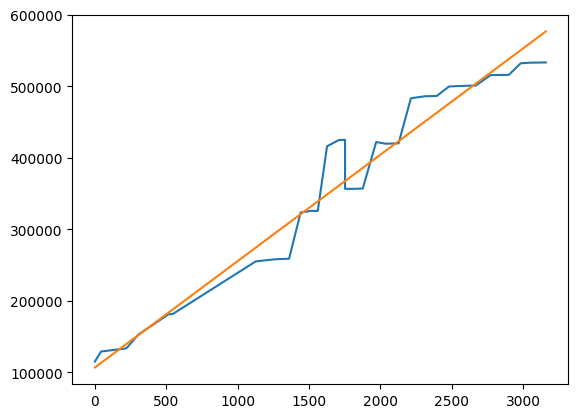

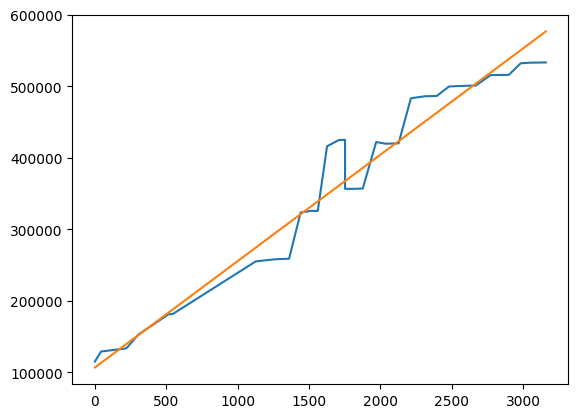

In [55]:

x = np.array(maj_min_p["relative_day"])
y = np.array(maj_min_p["nb_code"])

reg = LinearRegression().fit(x.reshape(-1,1), y.reshape(-1,1))
plt.plot(x, y)
plt.plot(x, reg.predict(x.reshape(-1,1)))
# Your code for regression plot

### Correlation 
Correlation is generally used to analyse the relationship between variables. Here, analyse the relationship between the number of lines of code and the number of files using Spearman correlation and Pearson correlation by considering Dataset A. Report the correlation upto 3 decimal places

In [ ]:
# Your code for correlation
# find correlation between  number of lines of code and number of file with Spearman correlation
from scipy.stats import spearmanr
from scipy.stats import pearsonr

x = np.array(maj_min_p["nb_nfiles"])
y = np.array(maj_min_p["nb_code"])

spearman = spearmanr(x, y)
pearson = pearsonr(x, y)

print("Spearman corr :", spearman.statistic)
print("Pearson corr :", pearson.statistic)



### Questions:
4. Do you find any difference in correlation values between Pearson and Spearman? Which one is preferable for this use case? why?

They are very similar but I will prefer Pearson because we work with linear model.
As Pearson computes how linearly close are the variable between each other

5. Based on the above correlation value, how much is the number of lines of code related to the number of files?

Really really highly correlated, at 99%

### Prediction
Consider Dataset A for this task. Drop the last two data points in "number of lines of code" (LOC) (i.e. drop (LOC) corresponding to v4.4.1 and v4.4.2) and forecast the values for (LOC) for v4.4.1 and v4.4.2 using a basic linear/polynimial regression model.
1. Drop the last two data points
2. Build a basic regression model
3. Ask the model to forecast the next two data points
4. Plot the LOC original and forecasted in the same plot. x-axis = date, y-axis = number of lines of code

In [ ]:
# Your code here
import matplotlib.dates as dates

polynomial_degree = 4

test = maj_min_p.loc[(maj_min_p['major.minor.patch'] == '4.4.2') | (maj_min_p['major.minor.patch'] == '4.4.1')]
train = maj_min_p.drop(test.index)

train_X = dates.date2num(train['relative_day'].copy()).reshape(-1, 1)
train_X = PolynomialFeatures(degree=polynomial_degree, include_bias=False).fit_transform(train_X)
train_y = train['nb_code']

In [ ]:
# Your code here
model = LinearRegression()
model.fit(train_X, train_y)

In [32]:
# Your code here
all_X = dates.date2num(maj_min_p['relative_day'].copy()).reshape(-1, 1)
all_X = PolynomialFeatures(degree=polynomial_degree, include_bias=False).fit_transform(all_X)
all_y = maj_min_p['nb_code']

predict_y = model.predict(all_X)

res = maj_min_p[['relative_day', 'major.minor.patch', 'nb_code']].copy()
res['predicted nb_code'] = predict_y
res.head()

,relative_day,major.minor.patch,nb_code,predicted nb_code
0,0,1.4.0,115336,102040.572466
1,43,1.5.0,129319,108618.075239
2,211,1.5.1,133424,134319.385838
3,223,1.5.2,134275,136155.386305
4,303,1.6.1,152705,148396.045566


In [ ]:
# Your plotting code here
plt.figure()
plt.plot(res['relative_day'], res['nb_code'], label='real nb of lines of code')
plt.plot(res['relative_day'], res['predicted nb_code'], label='predicted nb of lines of code')
plt.legend()
plt.show()



In [ ]:
from sklearn.metrics import r2_score, mean_squared_error


print(r2_score(res["nb_code"], res["predicted nb_code"]))
print(mean_squared_error(res["nb_code"], res["predicted nb_code"])**(1/2))

### Questions:
6. What is the polynomial degree that you adopted to build the model? Why? 

I choose 4 because it is the degree that has the best result among my tests

7. What is the coefficient of determination? (R-squared)

0.95222

8. What is the Root mean square error for the forecasted values?

29662.7179

### Filtering on coding langugage

Consider the prominent langugages used in this software project and plot the distribution of their LOC in a pie chart for the first and the last versions

In [34]:
# Your code to get the data for LOC of first and last versions

for tag, val in zip(["1.4", "v4.4.2"], ["first", "last"]):
    command = f'git -C {eucalyptus_project_path} reset --hard {tag}'
    process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    output, error = process.communicate()
    out = "\n".join(output.decode("utf-8").split("\n")[4:])
    command_2 = f'cloc  --csv --out {val}.csv {eucalyptus_project_path}'
    process_2 = subprocess.Popen(command_2, stdout=subprocess.PIPE, shell=True)

first, last = pd.read_csv ("first.csv", index_col=0), pd.read_csv("last.csv", index_col=0)


Unable to read ../eucalyptus/clc/modules/cluster-manager/src/main/java/com/eucalyptus/cloud/VmInstanceLifecycleHelper.groovy
Unable to read ../eucalyptus/clc/modules/cluster-manager/src/main/java/com/eucalyptus/cloud/VmInstanceLifecycleHelperDiscovery.groovy
Unable to read ../eucalyptus/clc/modules/cluster-manager/src/main/java/com/eucalyptus/cloud/VmInstanceLifecycleHelpers.groovy
Unable to read ../eucalyptus/clc/modules/cluster-manager/src/main/java/com/eucalyptus/cloud/VmRunType.java
Unable to read ../eucalyptus/clc/modules/cluster-manager/src/main/java/com/eucalyptus/cloud/run/AdmissionControl.java
Unable to read ../eucalyptus/clc/modules/cluster-manager/src/main/java/com/eucalyptus/cloud/run/Allocations.java
Unable to read ../eucalyptus/clc/modules/cluster-manager/src/main/java/com/eucalyptus/cloud/run/ClusterAllocator.java
Unable to read ../eucalyptus/clc/modules/cluster-manager/src/main/java/com/eucalyptus/cloud/run/ContractEnforcement.java
Unable to read ../eucalyptus/clc/modul

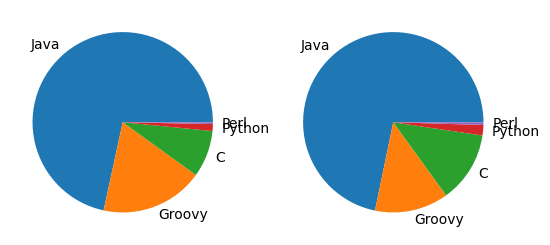

In [35]:
# Your pie chart code here
languages = ['Java', 'C', 'Groovy', 'Perl', 'Python']

# filter dataframes with only the languages of interest
first = first[first['language'].isin(languages)]
last = last[last['language'].isin(languages)]

fig, axes = plt.subplots(1,2)

axes[0].pie(first.code, labels=first.language)
axes[1].pie(last.code, labels=first.language)
plt.show()


### Question:
9. Do you find any significant difference in the distribution of the language used in the software project between its first and the last version? If so, what is the difference and how much is it?

No, the distribution remains the same (almost), the growth is in line of code and does not concern a particuliar language

### Law of increasing growth for coding langugages

Get the LOC for each of the considered prominent langugages (as above) for each version of the form major.minor.patch  
1) Plot the date (x-axis) vs LOC (y-axis) 
2) Plot the date (x-axis) vs proportional LOC (y-axis). Proportional is LOC of a language/total number of LOC

In [36]:
# Your code to get the LOC for each prominent language of each version
#Dataframe to store the data
import datetime

df = pd.DataFrame(columns=['tag', 'rDate', 'JavaCode', 'JavaComment', 'JavaBlank', 'CCode', 'CComment', 'CBlank', 'GroovyCode', 'GroovyComment', 'GroovyBlank', 'PerlCode', 'PerlComment', 'PerlBlank', 'PythonCode', 'PythonComment', 'PythonBlank'])
for tag in major_minor_patch_versions:
    command = f'git -C {eucalyptus_project_path} reset --hard {tag}'
    process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    command = f'cloc {eucalyptus_project_path} --json'
    process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    output = process.communicate()[0].decode('utf-8')
    data = json.loads(output)
    if "Java" in data.keys():
        JavaCode = data['Java']['code']
        JavaComment = data['Java']['comment']
        JavaBlank = data['Java']['blank']
    else:
        JavaCode = 0
        JavaComment = 0
        JavaBlank = 0
    if 'C' in data.keys():
        CCode = data['C']['code']
        CComment = data['C']['comment']
        CBlank = data['C']['blank']
    else:
        CCode = 0
        CComment = 0
        CBlank = 0
    if 'Groovy' in data.keys():
        GroovyCode = data['Groovy']['code']
        GroovyComment = data['Groovy']['comment']
        GroovyBlank = data['Groovy']['blank']
    else:
        GroovyCode = 0
        GroovyComment = 0
        GroovyBlank = 0
    if 'Perl' in data.keys():
        PerlCode = data['Perl']['code']
        PerlComment = data['Perl']['comment']
        PerlBlank = data['Perl']['blank']
    else:
        PerlCode = 0
        PerlComment = 0
        PerlBlank = 0
    if 'Python' in data.keys():
        PythonCode = data['Python']['code']
        PythonComment = data['Python']['comment']
        PythonBlank = data['Python']['blank']
    else:
        PythonCode = 0
        PythonComment = 0
        PythonBlank = 0
    command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)|%(creatordate:short)" | sort -r'
    process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    rDates = process.communicate()[0].decode('utf-8').split('\n')
    for rDate in rDates:
        rDate = rDate.split('|')
        if rDate[0] == tag:
            rDate = datetime.datetime.strptime(rDate[1], '%Y-%m-%d')
            break
    df = df.append({'tag': tag, 'rDate': rDate, 'JavaCode': JavaCode, 'JavaComment': JavaComment, 'JavaBlank': JavaBlank, 'CCode': CCode, 'CComment': CComment, 'CBlank': CBlank, 'GroovyCode': GroovyCode, 'GroovyComment': GroovyComment, 'GroovyBlank': GroovyBlank, 'PerlCode': PerlCode, 'PerlComment': PerlComment, 'PerlBlank': PerlBlank, 'PythonCode': PythonCode, 'PythonComment': PythonComment, 'PythonBlank': PythonBlank}, ignore_index=True)



df["TotJava"] = df["JavaCode"] + df["JavaComment"] + df["JavaBlank"]
df["TotC"] = df["CCode"] + df["CComment"] + df["CBlank"]
df["TotGroovy"] = df["GroovyCode"] + df["GroovyComment"] + df["GroovyBlank"]
df["TotPerl"] = df["PerlCode"] + df["PerlComment"] + df["PerlBlank"]
df["TotPython"] = df["PythonCode"] + df["PythonComment"] + df["PythonBlank"]

df

Unable to read ../eucalyptus/clc/modules/msgs/src/main/java/com/eucalyptus/util/fsm/AbstractTransitionAction.java
Unable to read ../eucalyptus/clc/modules/msgs/src/main/java/com/eucalyptus/util/fsm/AtomicMarkedState.java
Unable to read ../eucalyptus/clc/modules/msgs/src/main/java/com/eucalyptus/util/fsm/Automata.java
Unable to read ../eucalyptus/clc/modules/msgs/src/main/java/com/eucalyptus/util/fsm/ExistingTransitionException.java
Unable to read ../eucalyptus/clc/modules/msgs/src/main/java/com/eucalyptus/util/fsm/HasStateMachine.java
Unable to read ../eucalyptus/clc/modules/msgs/src/main/java/com/eucalyptus/util/fsm/OrderlyTransitionException.java
Unable to read ../eucalyptus/clc/modules/msgs/src/main/java/com/eucalyptus/util/fsm/SplitTransition.java
Unable to read ../eucalyptus/clc/modules/msgs/src/main/java/com/eucalyptus/util/fsm/StateMachine.java
Unable to read ../eucalyptus/clc/modules/msgs/src/main/java/com/eucalyptus/util/fsm/StateMachineBuilder.java
Unable to read ../eucalyptu

,tag,rDate,JavaCode,JavaComment,JavaBlank,CCode,CComment,CBlank,GroovyCode,GroovyComment,...,PerlComment,PerlBlank,PythonCode,PythonComment,PythonBlank,TotJava,TotC,TotGroovy,TotPerl,TotPython
0,1.4,2009-01-06,21281,6750,4076,8914,598,1798,1766,114,...,53,60,0,0,0,32107,11310,2322,565,0
1,1.5.0,2009-02-18,29898,13558,5458,11701,945,2322,2012,113,...,75,126,0,0,0,48914,14968,2625,1037,0
2,1.5.1,2009-08-05,35003,13506,6280,12676,1000,2404,2218,143,...,95,145,0,0,0,54789,16080,2907,1180,0
3,1.5.2,2009-08-17,33486,7302,5912,14201,1084,2655,2297,139,...,95,145,0,0,0,46700,17940,2991,1180,0
4,1.6.1,2009-11-05,44375,27525,7477,15087,2569,3122,4548,1219,...,840,161,0,0,0,79377,20778,6535,1978,0
5,2.0.0,2010-06-05,61700,29019,9344,17622,2482,3516,5240,1279,...,843,187,0,0,0,100063,23620,7431,2136,0
6,2.0.1,2010-07-06,65668,29374,9845,21085,2861,4143,5501,1279,...,855,328,1062,2,235,104887,28089,7700,2742,1299
7,3.0.0,2012-02-07,108162,39347,17384,30821,4605,5945,7335,2385,...,1302,833,4000,2331,814,164893,41371,10777,7015,7145
8,3.0.1,2012-03-12,108832,40156,17489,30922,4504,5947,7332,2385,...,1302,833,4000,2331,814,166477,41373,10774,7015,7145
9,3.1.0,2012-06-22,110481,41082,17863,29251,4408,5618,8488,2443,...,1303,832,2154,2276,467,169426,39277,12050,7028,4897


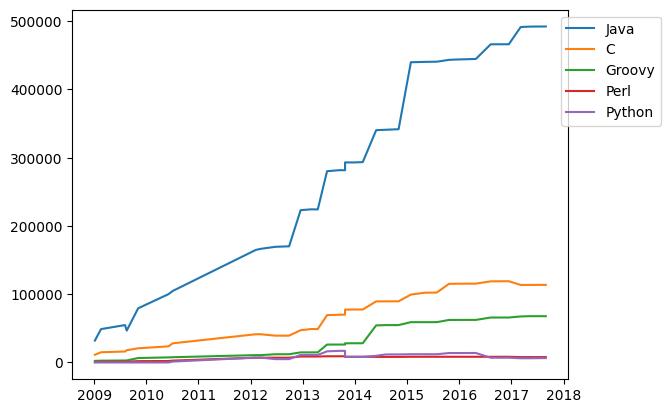

In [37]:
# Your plotting code here
#1)

plt.plot(df['rDate'],df["TotJava"],label='Java')
plt.plot(df['rDate'],df['TotC'],label='C')
plt.plot(df['rDate'],df['TotGroovy'],label='Groovy')
plt.plot(df['rDate'],df['TotPerl'],label='Perl')
plt.plot(df['rDate'],df['TotPython'],label='Python')
plt.legend( bbox_to_anchor=(1.2, 1.0))
plt.show()

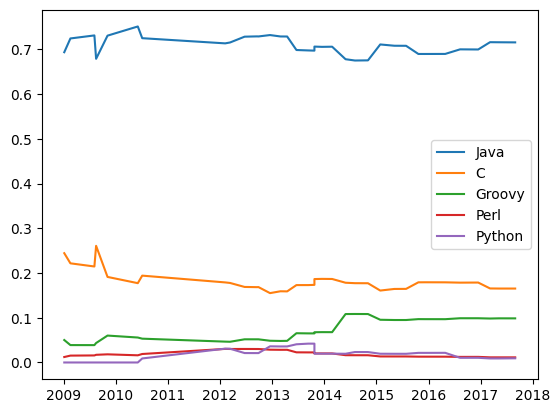

In [38]:
# 2)
#Computing the proportional LOC
df['total'] = df['TotJava'] + df['TotC'] + df['TotGroovy'] + df['TotPerl'] + df['TotPython']
total = df['total']
df['PropJava'] = df['TotJava']/total
df['PropC'] = df['TotC']/total
df['PropGroovy'] = df['TotGroovy']/total
df['PropPerl'] = df['TotPerl']/total
df['PropPython'] = df['TotPython']/total

plt.plot(df['rDate'],df['PropJava'],label='Java')
plt.plot(df['rDate'],df['PropC'],label='C')
plt.plot(df['rDate'],df['PropGroovy'],label='Groovy')
plt.plot(df['rDate'],df['PropPerl'],label='Perl')
plt.plot(df['rDate'],df['PropPython'],label='Python')

plt.legend()
plt.show()

### Question:
10. Does the prominent languages considered by you obey laws of increasing growth?

Except for Perl and Python, the prominent languages do follow the law, it is clear by the first plot.

11. Does this software project obey the Law of Increasing Growth?

I do consider that it follows the law of increasing growth even tho that 2 out of the 5 prominent language does not follow the law because those 2 languages represent less than 5% of the total codebase of the project. Meaning that 95% (more or less) of the codebase follows the law.

### Modify the CLOC parameters

1. Exclude all bank lines and verify if the Law of Increasing Growth still holds good for this filtering

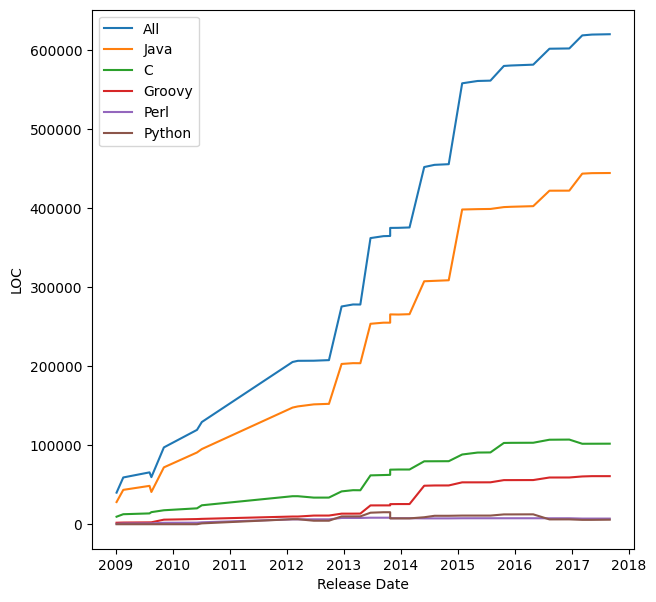

In [41]:
# Your code and plot here
df["JavaNoBlank"] = df["JavaCode"] + df["JavaComment"]
df["CNoBlank"] = df["CCode"] + df["CComment"]
df["GroovyNoBlank"] = df["GroovyCode"] + df["GroovyComment"]
df["PerlNoBlank"] = df["PerlCode"] + df["PerlComment"]
df["PythonNoBlank"] = df["PythonCode"] + df["PythonComment"]
df["TotNoBlank"] = df["JavaNoBlank"] + df["CNoBlank"] + df["GroovyNoBlank"] + df["PerlNoBlank"] + df["PythonNoBlank"]

plt.figure(figsize=(7,7))
plt.plot(df['rDate'],df['TotNoBlank'],label='All')
plt.plot(df['rDate'],df['JavaNoBlank'],label='Java')
plt.plot(df['rDate'],df['CNoBlank'],label='C')
plt.plot(df['rDate'],df['GroovyNoBlank'],label='Groovy')
plt.plot(df['rDate'],df['PerlNoBlank'],label='Perl')
plt.plot(df['rDate'],df['PythonNoBlank'],label='Python')
plt.xlabel('Release Date')
plt.ylabel('LOC')
plt.legend()
plt.show()


2. Exclude all comment lines and verify if the Law of Increasing Growth still holds good for this filtering

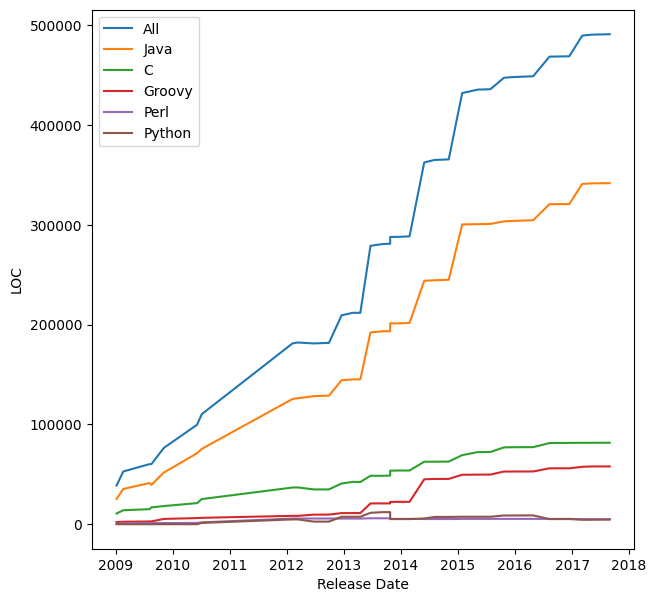

In [42]:
# Your code and plot here
# Your code and plot here
df["JavaNoComment"] = df["JavaCode"] + df["JavaBlank"]
df["CNoComment"] = df["CCode"] + df["CBlank"]
df["GroovyNoComment"] = df["GroovyCode"] + df["GroovyBlank"]
df["PerlNoComment"] = df["PerlCode"] + df["PerlBlank"]
df["PythonNoComment"] = df["PythonCode"] + df["PythonBlank"]
df["TotNoComment"] = df["JavaNoComment"] + df["CNoComment"] + df["GroovyNoComment"] + df["PerlNoComment"] + df["PythonNoComment"]

plt.figure(figsize=(7,7))
plt.plot(df['rDate'],df['TotNoComment'],label='All')
plt.plot(df['rDate'],df['JavaNoComment'],label='Java')
plt.plot(df['rDate'],df['CNoComment'],label='C')
plt.plot(df['rDate'],df['GroovyNoComment'],label='Groovy')
plt.plot(df['rDate'],df['PerlNoComment'],label='Perl')
plt.plot(df['rDate'],df['PythonNoComment'],label='Python')
plt.xlabel('Release Date')
plt.ylabel('LOC')
plt.legend()
plt.show()

3. Exclude all non-code files (or consider prominent coding langugages used in the project) and and verify if the Law of Increasing Growth still holds good for this filtering

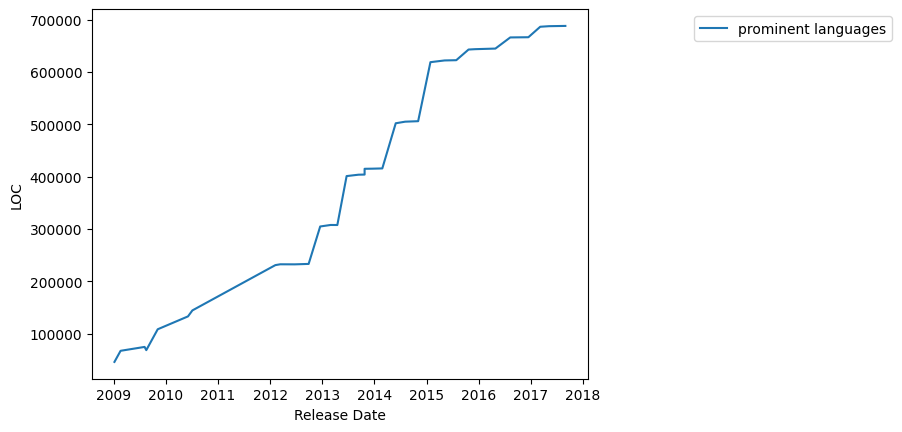

In [43]:
# Your code and plot here
plt.plot(df['rDate'],df['total'],label='prominent languages')
plt.xlabel('Release Date')
plt.ylabel('LOC')
plt.legend( bbox_to_anchor=(1.2, 1.0))
plt.show()

### 2.3 Law of Continuing Change
1. Using CLOC tool, find the features such as number of lines of code that are added, modified, removed and same between two consecutive versions
2. Consider all the three component versions (major.minor.patch) - Dataset A
3. Consider only the minor versions (major.minor) - Dataset B
4. Having all the features in the same plot, create two plots (one for Dataset A and another for Dataset B) the outcomes with date on x-axis and the number on y-axis.
5. Make a subplot of all the features

Code hint:
For each pair of tags, set the original project to the required tag and the copy of the original project to the next tag.
To get the required data in json format - "command = f'CLOC/cloc --git --diff {first_project_path} {second_project_path} --json'"

In [49]:
eucalyptus_copy_project_path = '../eucalyptus_copy/' # your path to the copy of your project here
eucalyptus_project_path = "../eucalyptus/"

In [52]:
# Your code here to get the data
def extract_data(tags, prominent_languages):
    df = pd.DataFrame(columns=['rDate', 'tag', 'next', 'added', 'same', 'modified', 'removed'])
    for i in range(len(tags)-1):
        tag = tags[i]
        next = tags[i+1]

        command = f'git -C {eucalyptus_project_path} reset --hard {tag}'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)

        command = f'git -C {eucalyptus_copy_project_path} reset --hard {next}'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)

        command = f'cloc --git --diff {eucalyptus_project_path} {eucalyptus_copy_project_path} --json'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)

        output = process.communicate()[0].decode('utf-8')

        data = json.loads(output)
        added = 0
        same = 0
        modified = 0
        removed = 0
        for language in prominent_languages:
            if language in data["added"].keys():
                added += data["added"][language]['code']
                same += data["same"][language]['code']
                modified += data["modified"][language]['code']
                removed += data["removed"][language]['code']

        command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)|%(creatordate:short)" | sort -r'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
        rDates = process.communicate()[0].decode('utf-8').split('\n')
        for rDate in rDates:
            rDate = rDate.split('|')
            if rDate[0] == tag:
                rDate = datetime.datetime.strptime(rDate[1], '%Y-%m-%d')
                break

        df = df.append({'rDate': rDate, 'tag': tag, 'next': next, 'added': added, 'same': same, 'modified': modified, 'removed': removed}, ignore_index=True)
    return df

In [53]:
# Your code here to get the dates corresponding to the tags
prominent_languages = ['Java', 'C', 'Groovy', 'Perl', 'Python']
df = extract_data(major_minor_patch_versions, prominent_languages)

/tmp/ipykernel_101603/1712305678.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'rDate': rDate, 'tag': tag, 'next': next, 'added': added, 'same': same, 'modified': modified, 'removed': removed}, ignore_index=True)
/tmp/ipykernel_101603/1712305678.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'rDate': rDate, 'tag': tag, 'next': next, 'added': added, 'same': same, 'modified': modified, 'removed': removed}, ignore_index=True)
/tmp/ipykernel_101603/1712305678.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'rDate': rDate, 'tag': tag, 'next': next, 'added': added, 'same': same, 'modified': modified, 'removed': removed}, ignore_index=True)
/tmp/ipykernel_101603/171

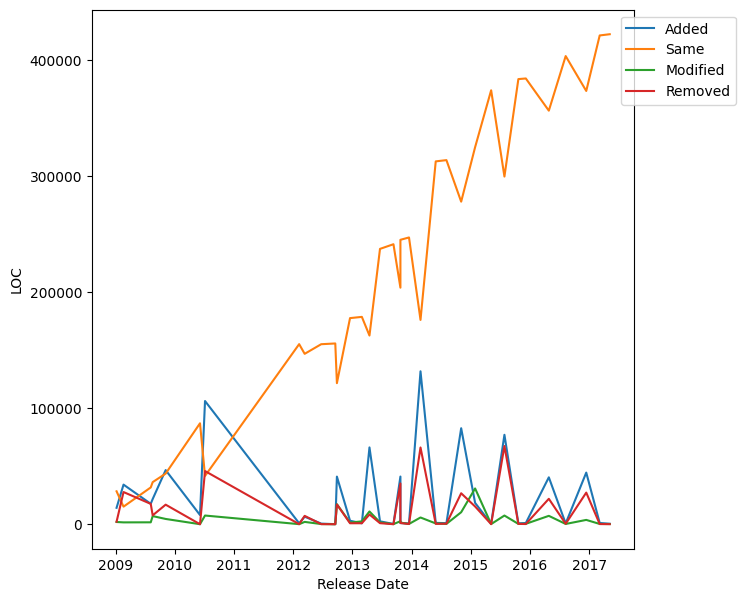

In [56]:
# Your plotting code here (all the features in a single plot)
plt.figure(figsize=(7,7))
plt.plot(df['rDate'],df['added'],label='Added')
plt.plot(df['rDate'],df['same'],label='Same')
plt.plot(df['rDate'],df['modified'],label='Modified')
plt.plot(df['rDate'],df['removed'],label='Removed')
plt.xlabel('Release Date')
plt.ylabel('LOC')
plt.legend( bbox_to_anchor=(1.2, 1.0))
plt.show()

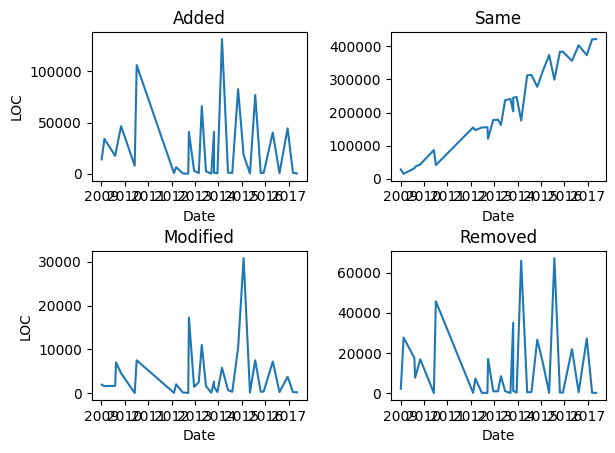

In [58]:
# Your plotting code here, different plot for each feature
fig,axes = plt.subplots(2,2)

fig.tight_layout(pad=3)
axes[0,0].plot(df['rDate'],df['added'],label='Added')
axes[0,0].set_title('Added')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('LOC')

axes[0,1].plot(df['rDate'],df['same'],label='Same')
axes[0,1].set_title('Same')
axes[0,1].set_xlabel('Date')

axes[1,0].plot(df['rDate'],df['modified'],label='Modified')
axes[1,0].set_title('Modified')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('LOC')

axes[1,1].plot(df['rDate'],df['removed'],label='Removed')
axes[1,1].set_title('Removed')
axes[1,1].set_xlabel('Date')

plt.show()

### Questions:
1. Do you find the Law of Continuing Change holding good here? Prove it empirically.

Yes because as we can see the number of line added, removed et modified vary through the developpement.

2. Does the law of increasing growth too hold good here?

Yes, clearly the number of line of code increase over time

### Law of continuing change for coding languages
Consider the prominent languages used in this software project for versions of the form major.minor.patch
1. Obtain the number of lines of code that are added, modified, removed and same between two consecutive versions
2. Make plots for each parameter (added, modified, removed and same) with date on x-axis
    a) y-axis number of lines of code
    b) y-axis proportional number of lines of code (number of lines of code of that language/total number of lines of code)

In [60]:
# Your code here


def extract_data_2(tags, prominent_languages):
    df_dict = {}
    for language in prominent_languages:
        df_dict[language] = df = pd.DataFrame(columns=['rDate', 'tag', 'next', 'added', 'same', 'modified', 'removed'])
    for i in range(len(tags)-1):
        tag = tags[i]
        next = tags[i+1]

        command = f'git -C {eucalyptus_project_path} reset --hard {tag}'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)

        command = f'git -C {eucalyptus_copy_project_path} reset --hard {next}'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)

        command = f'cloc --git --diff {eucalyptus_project_path} {eucalyptus_copy_project_path} --json'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)

        output = process.communicate()[0].decode('utf-8')

        data = json.loads(output)

        command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)|%(creatordate:short)" | sort -r'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
        rDates = process.communicate()[0].decode('utf-8').split('\n')
        for rDate in rDates:
            rDate = rDate.split('|')
            if rDate[0] == tag:
                rDate = datetime.datetime.strptime(rDate[1], '%Y-%m-%d')
                break

        for language in prominent_languages:
            if language in data["added"].keys():
                added = data["added"][language]["code"]
                same = data["same"][language]["code"]
                modified = data["modified"][language]["code"]
                removed = data["removed"][language]["code"]
            else:
                added = 0
                same = 0
                modified = 0
                removed = 0

            df_dict[language] = df_dict[language].append({'rDate': rDate, 'tag': tag, 'next': next, 'added': added, 'same': same, 'modified': modified, 'removed': removed}, ignore_index=True)
    return df_dict

df_3= extract_data_2(major_minor_patch_versions, prominent_languages)



/tmp/ipykernel_101603/51477279.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dict[language] = df_dict[language].append({'rDate': rDate, 'tag': tag, 'next': next, 'added': added, 'same': same, 'modified': modified, 'removed': removed}, ignore_index=True)
/tmp/ipykernel_101603/51477279.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dict[language] = df_dict[language].append({'rDate': rDate, 'tag': tag, 'next': next, 'added': added, 'same': same, 'modified': modified, 'removed': removed}, ignore_index=True)
/tmp/ipykernel_101603/51477279.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dict[language] = df_dict[language].append({'rDate': rDate, 'tag': tag, 'next': next, 'added': added, 'same': same, 'mo

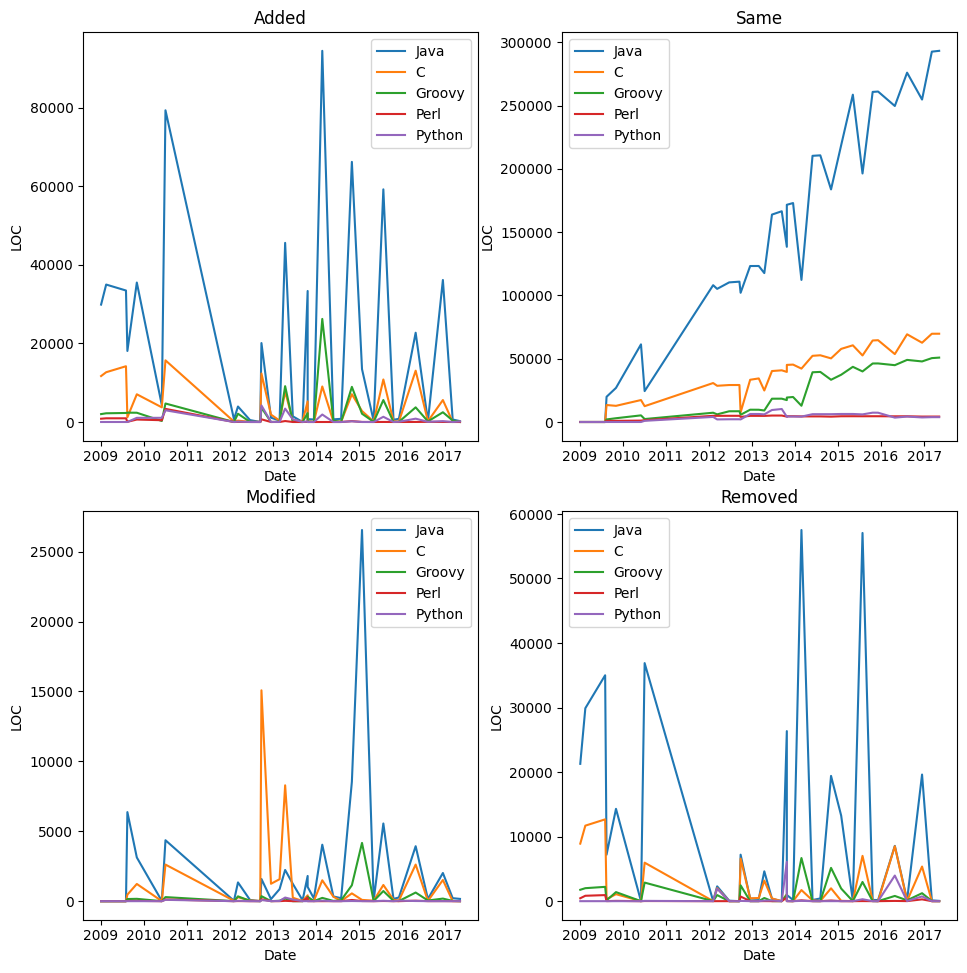

In [62]:
# Your plotting code here
fig,axes = plt.subplots(2,2, figsize=(10,10))

fig.tight_layout(pad=3)

axes[0,0].plot(df_3['Java']['rDate'],df_3['Java']['added'],label='Java')
axes[0,0].plot(df_3['C']['rDate'],df_3['C']['added'],label='C')
axes[0,0].plot(df_3['Groovy']['rDate'],df_3['Groovy']['added'],label='Groovy')
axes[0,0].plot(df_3['Perl']['rDate'],df_3['Perl']['added'],label='Perl')
axes[0,0].plot(df_3['Python']['rDate'],df_3['Python']['added'],label='Python')
axes[0,0].set_title('Added')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('LOC')
axes[0,0].legend()

axes[0,1].plot(df_3['Java']['rDate'],df_3['Java']['same'],label='Java')
axes[0,1].plot(df_3['C']['rDate'],df_3['C']['same'],label='C')
axes[0,1].plot(df_3['Groovy']['rDate'],df_3['Groovy']['same'],label='Groovy')
axes[0,1].plot(df_3['Perl']['rDate'],df_3['Perl']['same'],label='Perl')
axes[0,1].plot(df_3['Python']['rDate'],df_3['Python']['same'],label='Python')
axes[0,1].set_title('Same')
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('LOC')
axes[0,1].legend()

axes[1,0].plot(df_3['Java']['rDate'],df_3['Java']['modified'],label='Java')
axes[1,0].plot(df_3['C']['rDate'],df_3['C']['modified'],label='C')
axes[1,0].plot(df_3['Groovy']['rDate'],df_3['Groovy']['modified'],label='Groovy')
axes[1,0].plot(df_3['Perl']['rDate'],df_3['Perl']['modified'],label='Perl')
axes[1,0].plot(df_3['Python']['rDate'],df_3['Python']['modified'],label='Python')
axes[1,0].set_title('Modified')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('LOC')
axes[1,0].legend()

axes[1,1].plot(df_3['Java']['rDate'],df_3['Java']['removed'],label='Java')
axes[1,1].plot(df_3['C']['rDate'],df_3['C']['removed'],label='C')
axes[1,1].plot(df_3['Groovy']['rDate'],df_3['Groovy']['removed'],label='Groovy')
axes[1,1].plot(df_3['Perl']['rDate'],df_3['Perl']['removed'],label='Perl')
axes[1,1].plot(df_3['Python']['rDate'],df_3['Python']['removed'],label='Python')
axes[1,1].set_title('Removed')
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('LOC')
axes[1,1].legend()


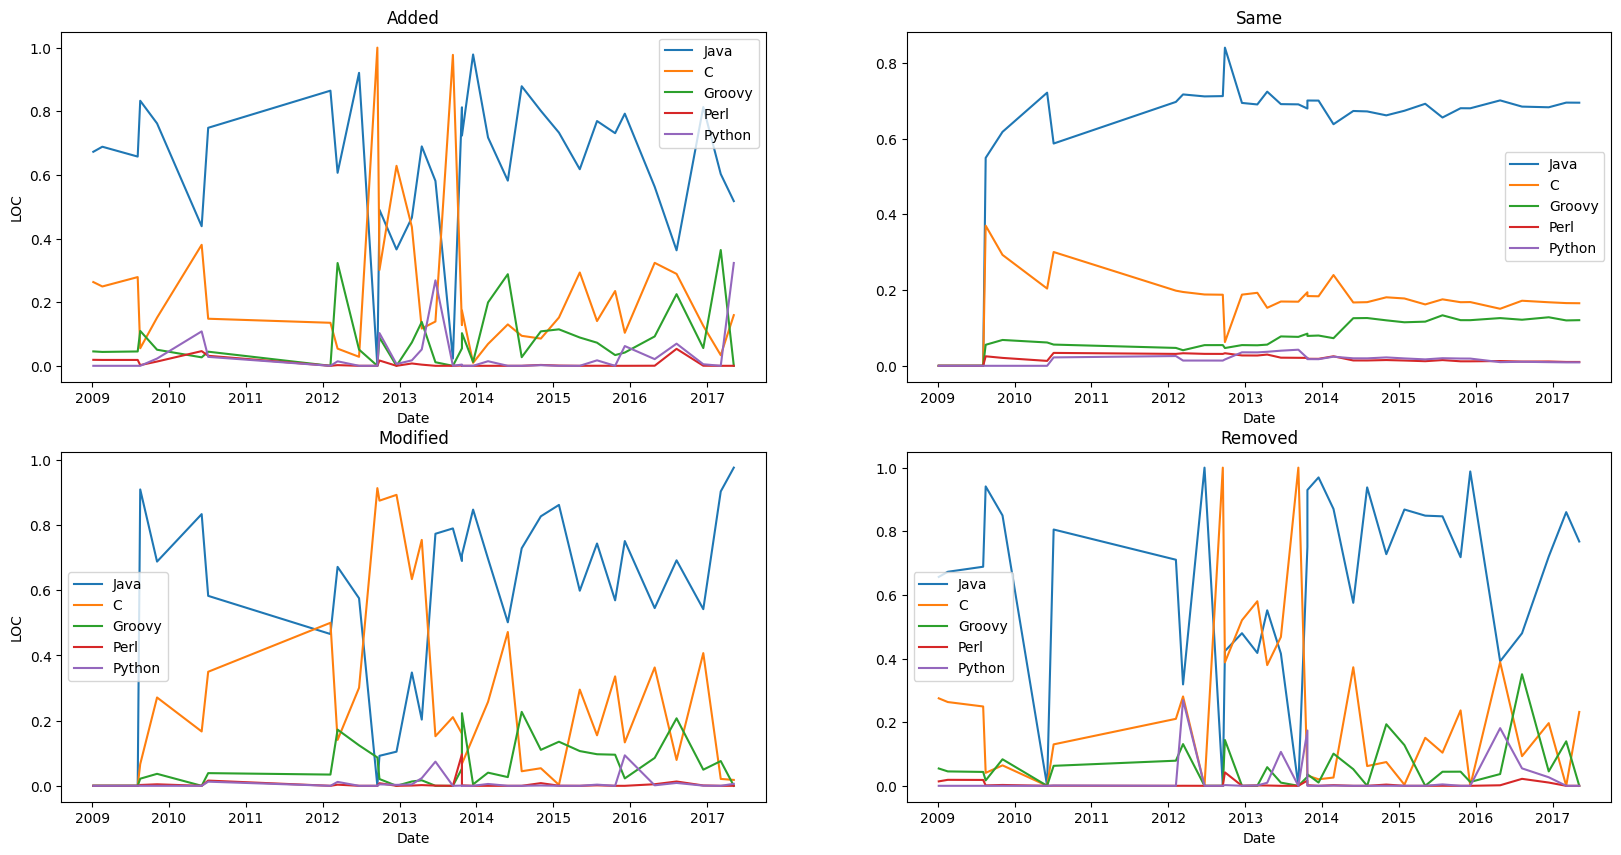

In [63]:


# Your plotting code here
prominent_languages = ['Java', 'C', 'Groovy', 'Perl', 'Python']

fig,axes = plt.subplots(2,2, figsize=(20, 10))

totalAdded = df_3['Java']['added'] + df_3['C']['added'] + df_3['Groovy']['added'] + df_3['Perl']['added'] + df_3['Python']['added']
totalSame = df_3['Java']['same'] + df_3['C']['same'] + df_3['Groovy']['same'] + df_3['Perl']['same'] + df_3['Python']['same']
totalModified = df_3['Java']['modified'] + df_3['C']['modified'] + df_3['Groovy']['modified'] + df_3['Perl']['modified'] + df_3['Python']['modified']
totalRemoved = df_3['Java']['removed'] + df_3['C']['removed'] + df_3['Groovy']['removed'] + df_3['Perl']['removed'] + df_3['Python']['removed']

for language in prominent_languages:
    added = []
    same = []
    modified = []
    removed = []

    for i in range(len(df_3[language])):
        added.append(df_3[language]['added'][i]/totalAdded[i] if totalAdded[i] != 0 else 0)
        same.append(df_3[language]['same'][i]/totalSame[i] if totalSame[i] != 0 else 0)
        modified.append(df_3[language]['modified'][i]/totalModified[i] if totalModified[i] != 0 else 0)
        removed.append(df_3[language]['removed'][i]/totalRemoved[i] if totalRemoved[i] != 0 else 0)


    axes[0,0].plot(df_3[language]['rDate'],added,label=language)
    axes[0,1].plot(df_3[language]['rDate'],same,label=language)
    axes[1,0].plot(df_3[language]['rDate'],modified,label=language)
    axes[1,1].plot(df_3[language]['rDate'],removed,label=language)



axes[0,0].set_title('Added')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('LOC')
axes[0,0].legend()

axes[0,1].set_title('Same')
axes[0,1].set_xlabel('Date')
axes[0,1].legend()


axes[1,0].set_title('Modified')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('LOC')
axes[1,0].legend()

axes[1,1].set_title('Removed')
axes[1,1].set_xlabel('Date')
axes[1,1].legend()

plt.show()



### Question:
3. Does the law of continuing change obey here for all the considered prominent langugages? Comment on the rate of growth.

Yes it does because even tho the "same" code base is high for some language (see java) we can see with the other plot that there are no period of "non change", there are always changes either addition, deletion or modification

4. Does this software project obey Law of Continuing Change?

yes for the same reason as above